In [1]:
import datetime
import json
import numpy as np
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from datetime import date
import timm
# assert timm.__version__ == "0.3.2" # version check
from copy import deepcopy

import os
import sys
sys.path.insert(1, '/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/code')
sys.path.insert(1, '/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/segmenter')

/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import fed_mae.models_vit as models_vit
from fed_mae.engine_for_finetuning import train_one_epoch
import util.misc as misc
from util.FedAvg_utils import Partial_Client_Selection, valid, average_model
from util.data_utils import DatasetFLFinetune, create_dataset_and_evalmetrix
from util.start_config import print_options

## Segmentation

Define usefull variables and helper functions

In [3]:
mean = [0.6821, 0.4575, 0.2626]
std  = [0.1324, 0.1306, 0.1022]
from torchvision import  transforms
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

mask_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

def imshow(inp, title=None, mean=np.array([ 0.7013, -0.1607, -0.7902]), std=np.array([0.5904, 0.5008, 0.3771])):
    """Input shound be tensor [3,224,224]"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = mean
    # std = std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def imshow2(inp, mask, alpha=0.5, title=None, mean=np.array([0.6821, 0.4575, 0.2626]), std=np.array([0.1324, 0.1306, 0.1022])):
    """Input shound be tensor [3,224,224]"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = mean
    # std = std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.imshow(mask, cmap='jet', alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def torch2numpy(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = mean
    # std = std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

### Dataloader

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import glob
import matplotlib.pyplot as plt

class REFUSEDataset(Dataset):
    def __init__(self, 
                data_dir = '/mnt/c/Users/PCM/Dropbox/ee638/REFUGE2/', 
                phase='train', 
                mode='multiclass_contrastive', 
                datalen = 100,
                seed = 100):
        self.folder_path = data_dir
        self.phase = phase
        self.img_files = glob.glob(self.folder_path + self.phase + '/images/*')
        self.mask_imgs = glob.glob(self.folder_path + self.phase + '/mask/*')
        self.data_transforms = data_transforms[phase]
        self.mask_transforms = mask_transforms
        self.datalen = len(self.img_files)
        
    def __getitem__(self, index):
        img = self.img_files[index]
        mask = self.mask_imgs[index]

        img = self.data_transforms(Image.open(img))
        mask = self.mask_transforms(Image.open(mask))

        mask = (mask[0] > 0) & (mask[0] < 1) * 1

        return img, mask
    
    def __len__(self):
        return self.datalen


In [5]:
image_datasets = {x: REFUSEDataset(phase=x) for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
im, mask = image_datasets['train'][3]

cuda:0


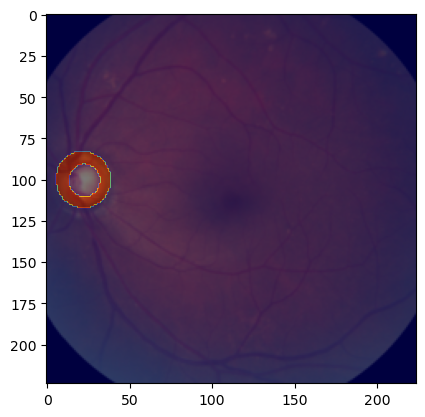

In [6]:
imshow2(im, mask, alpha = 0.5)

### Define the Segm model

In [7]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [8]:


class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        return self.layers(x)


class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.deconv = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        return self.deconv(x)


class UNETR_2D(nn.Module):
    def __init__(self, cf, pretrained = '/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/SSFL/split2/checkpoint-6.pth', device=device):
        super().__init__()
        self.cf = cf
        self.encoder = models_vit.__dict__['vit_base_patch16'](
        num_classes=5,
        drop_path_rate=0.1,
        global_pool=True,
        )

        model = models_vit.__dict__['vit_base_patch16'](
            num_classes=5,
            drop_path_rate=0.1,
            global_pool=True,
        )
        if(pretrained):
            state_dict = torch.load(pretrained)
            model.load_state_dict(state_dict['model'], strict=False)
        model.to(device)
        """ Patch + Position Embeddings """
        # self.patch_embed = nn.Linear(
        #     cf["patch_size"]*cf["patch_size"]*cf["num_channels"],
        #     cf["hidden_dim"]
        # )
        self.patch_embed = self.encoder.patch_embed
        
        self.positions = torch.arange(start=0, end=cf["num_patches"], step=1, dtype=torch.int32).to(device)
        self.pos_embed = nn.Embedding(cf["num_patches"], cf["hidden_dim"]).to(device)

        """ Transformer Encoder """
        # self.trans_encoder_layers = []

        # for i in range(cf["num_layers"]):
        #     layer = nn.TransformerEncoderLayer(
        #         d_model=cf["hidden_dim"],
        #         nhead=cf["num_heads"],
        #         dim_feedforward=cf["mlp_dim"],
        #         dropout=cf["dropout_rate"],
        #         activation=nn.GELU(),
        #         batch_first=True
        #     )
        #     self.trans_encoder_layers.append(layer)
        self.trans_encoder_layers = self.encoder.blocks
        
        """ CNN Decoder """
        ## Decoder 1
        self.d1 = DeconvBlock(cf["hidden_dim"], 512)
        self.s1 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 512),
            ConvBlock(512, 512)
        )
        self.c1 = nn.Sequential(
            ConvBlock(512+512, 512),
            ConvBlock(512, 512)
        )

        ## Decoder 2
        self.d2 = DeconvBlock(512, 256)
        self.s2 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 256),
            ConvBlock(256, 256),
            DeconvBlock(256, 256),
            ConvBlock(256, 256)
        )
        self.c2 = nn.Sequential(
            ConvBlock(256+256, 256),
            ConvBlock(256, 256)
        )

        ## Decoder 3
        self.d3 = DeconvBlock(256, 128)
        self.s3 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128)
        )
        self.c3 = nn.Sequential(
            ConvBlock(128+128, 128),
            ConvBlock(128, 128)
        )

        ## Decoder 4
        self.d4 = DeconvBlock(128, 64)
        self.s4 = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64)
        )
        self.c4 = nn.Sequential(
            ConvBlock(64+64, 64),
            ConvBlock(64, 64)
        )

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Patch + Position Embeddings """
        patch_embed = self.patch_embed(inputs)   ## [8, 256, 768]

        positions = self.positions
        pos_embed = self.pos_embed(positions)   ## [256, 768]

        x = patch_embed + pos_embed ## [8, 256, 768]

        """ Transformer Encoder """
        skip_connection_index = [3, 6, 9, 12]
        skip_connections = []

        for i in range(self.cf["num_layers"]):
            layer = self.trans_encoder_layers[i]
            x = layer(x)

            if (i+1) in skip_connection_index:
                skip_connections.append(x)

        """ CNN Decoder """
        z3, z6, z9, z12 = skip_connections

        ## Reshaping
        batch = inputs.shape[0]
        z0 = inputs.view((batch, self.cf["num_channels"], self.cf["image_size"], self.cf["image_size"]))

        shape = (batch, self.cf["hidden_dim"], self.cf["width_patches"], self.cf["width_patches"])
        z3 = z3.reshape(shape)
        z6 = z6.reshape(shape)
        z9 = z9.reshape(shape)
        z12 = z12.reshape(shape)


        ## Decoder 1
        x = self.d1(z12)
        s = self.s1(z9)
        x = torch.cat([x, s], dim=1)
        x = self.c1(x)

        ## Decoder 2
        x = self.d2(x)
        s = self.s2(z6)
        x = torch.cat([x, s], dim=1)
        x = self.c2(x)

        ## Decoder 3
        x = self.d3(x)
        s = self.s3(z3)
        x = torch.cat([x, s], dim=1)
        x = self.c3(x)

        ## Decoder 4
        x = self.d4(x)
        s = self.s4(z0)
        x = torch.cat([x, s], dim=1)
        x = self.c4(x)

        """ Output """
        output = self.output(x)

        return output

In [35]:
config = {}
config["image_size"] = 224
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 196
config["patch_size"] = 16
config["width_patches"] = 14
config["num_channels"] = 3
LOSS_NAME = "dicefocal" #ce/bce/dice
DATA_SPLIT = "split1" #split1/split2/central
unetr = UNETR_2D(config, pretrained=f'/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/SSFL/{DATA_SPLIT}/checkpoint-6.pth',device=device)
# unetr = UNETR_2D(config, pretrained=False,device=device)
# output = unetr(x)
# print(output.shape)

from monai.losses import DiceLoss, DiceFocalLoss
import torch.optim as optim
momentum = 0.9
lr = 0.01

# Define loss
if LOSS_NAME == "ce":
    criterion = nn.CrossEntropyLoss()
elif LOSS_NAME=='dicefocal':
    criterion= DiceFocalLoss(reduction='mean', sigmoid = True)
elif LOSS_NAME=='dice':
    criterion= DiceLoss(reduction='mean', sigmoid = True)

# criterion.= DiceLoss(reduction='mean', sigmoid = True)
optimizer_ft = optim.SGD([{'params': unetr.parameters()}], lr=lr, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in unetr.encoder.parameters():
    param.requires_grad = False
for param in unetr.trans_encoder_layers.parameters():
    param.requires_grad = False
for param in unetr.patch_embed.parameters():
    param.requires_grad = False

### Training and Evaluation

In [36]:
trainlosslist = []
vallosslist = []
unetr = unetr.to(device)
curr_loss = 100
for e in range(30):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    val_loss_test = 0.0
    for inputs, masks in dataloaders['train']:
        unetr.train()
        im = inputs.to(device)
        masks = masks.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        outputs = unetr(im)
        # print(outputs.shape)
        loss = criterion(outputs.squeeze(1), masks)

        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        trainlosslist.append(training_loss_test)

    for inputs, masks in dataloaders['val']:
        unetr.eval()
        im = inputs.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = unetr(im)
            # print(outputs.shape)
            dice = criterion(outputs, masks.unsqueeze(1))
            val_loss_test += dice.item()
            vallosslist.append(val_loss_test)

    if(val_loss_test <= curr_loss):
        curr_loss = val_loss_test
        print(f"New best mode at epoch {e}")
        today = date.today()
        torch.save(unetr.state_dict(), f'./pretrained/refuge/best-dice-unetr-{DATA_SPLIT}-{LOSS_NAME}-{str(today)}.pt')
    
    # scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}","avg val dice: ", val_loss_test / dataset_sizes['val']*batch_size['val'] , "avg traning loss: ", training_loss_test / dataset_sizes['train']*batch_size['train'])

New best mode at epoch 0
E0 With LR 0.01 avg val dice:  0.967883493900299 avg traning loss:  0.9977231693267822
E1 With LR 0.01 avg val dice:  0.9888251113891602 avg traning loss:  0.9263072776794433
New best mode at epoch 2
E2 With LR 0.01 avg val dice:  0.8319270443916321 avg traning loss:  0.9056267786026001
E3 With LR 0.01 avg val dice:  0.9261255812644958 avg traning loss:  0.8929123520851135
New best mode at epoch 4
E4 With LR 0.01 avg val dice:  0.7465714144706727 avg traning loss:  0.8859138298034668
E5 With LR 0.01 avg val dice:  0.8054921650886535 avg traning loss:  0.8773041462898254
New best mode at epoch 6
E6 With LR 0.01 avg val dice:  0.6526273107528686 avg traning loss:  0.8710995125770569
E7 With LR 0.01 avg val dice:  0.8223144865036011 avg traning loss:  0.8662658143043518
E8 With LR 0.01 avg val dice:  0.7527474617958069 avg traning loss:  0.8668422198295593
New best mode at epoch 9
E9 With LR 0.01 avg val dice:  0.5710415577888489 avg traning loss:  0.8626880335807

### Test

In [ ]:
from sklearn.metrics import jaccard_score

In [71]:
testsegm = UNETR_2D(config, device=device)
state_dict = torch.load('/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/refuge/best-dice-unetr-split1-dicefocal-2024-04-30.pt')
testsegm.load_state_dict(state_dict, strict=False)
testsegm.to(device)

UNETR_2D(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1)

In [39]:
test_dice = 0.0
test_jacard = 0.0

for inputs, masks in dataloaders['test']:
    testsegm.eval()
    im = inputs.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = testsegm(im)
        # print(outputs.shape)
        dice = criterion(outputs, masks.unsqueeze(1))
        test_dice += dice.item()
        # test_jacard += jaccard_score(outputs.cpu(), masks.unsqueeze(1).cpu())

In [40]:
masks.unsqueeze(1).cpu().shape

torch.Size([1, 1, 224, 224])

In [41]:
outputs.cpu()[0]

tensor([[[-4.7846, -5.1496, -3.1673,  ..., -3.6382, -4.5800, -5.3369],
         [-5.4986, -4.6406, -3.8422,  ..., -3.4457, -4.0519, -5.4016],
         [-3.9192, -3.9087, -3.3146,  ..., -3.9288, -5.0163, -5.1716],
         ...,
         [-3.8765, -2.2304, -2.5537,  ..., -3.4844, -5.1501, -4.9412],
         [-4.1658, -2.8559, -2.8175,  ..., -3.0102, -4.7931, -4.3453],
         [-5.5340, -5.0765, -4.0130,  ..., -5.6742, -7.1293, -5.9540]]])

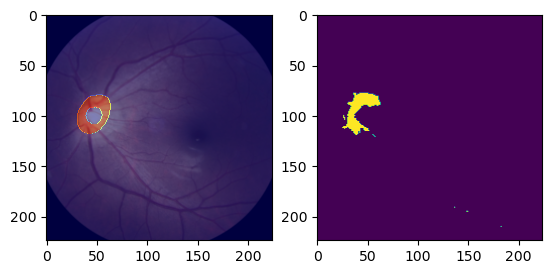

In [72]:
def imshow3(inp, mask, alpha=0.5, plt = plt, title=None, mean=np.array([0.6821, 0.4575, 0.2626]), std=np.array([0.1324, 0.1306, 0.1022])):
    """Input shound be tensor [3,224,224]"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = mean
    # std = std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.imshow(mask, cmap='jet', alpha=alpha)
    if title is not None:
        plt.title(title)

sample_test, label_test = image_datasets['test'][2]
fig, axs = plt.subplots(1, 2)
imshow3(sample_test, label_test, alpha = 0.5, plt=axs[0])
axs[1].imshow(testsegm(sample_test.unsqueeze(0).to(device))[0][0].cpu().detach().numpy() > 0)

In [ ]:
dice.item()

0.7140198945999146

In [51]:
test_dice/400

0.6942541103810072

# AUTO RUN

In [3]:
config = {}
config["image_size"] = 224
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 196
config["patch_size"] = 16
config["width_patches"] = 14
config["num_channels"] = 3

In [1]:
def run(config, no_of_exp=10, LOSS_NAME='dice', DATA_SPLIT='split1', req_grad = False, pretrained = True):
    all_test_dice = []
    for ii in range(no_of_exp):
        #Load dataset
        image_datasets = {x: REFUSEDataset(phase=x) for x in ['train', 'val', 'test']}
        batch_size = {'train':10, 'val':10, 'test':1}
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
        # dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # Define utils
        LOSS_NAME = LOSS_NAME #ce/bce/dice/dicefocal
        DATA_SPLIT = DATA_SPLIT #split1/split2/central
        if(pretrained):
            unetr = UNETR_2D(config, pretrained=f'/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/SSFL/{DATA_SPLIT}/checkpoint-6.pth',device=device)
        else:
            unetr = UNETR_2D(config, pretrained= None, device=device)
        from monai.losses import DiceLoss, DiceFocalLoss
        import torch.optim as optim
        momentum = 0.9
        lr = 0.01
        
        # Define loss
        if LOSS_NAME == "ce":
            criterion = nn.CrossEntropyLoss()
        elif LOSS_NAME=='dicefocal':
            criterion= DiceFocalLoss(reduction='mean', sigmoid = True)
        elif LOSS_NAME=='dice':
            criterion= DiceLoss(reduction='mean', sigmoid = True)

        # criterion.= DiceLoss(reduction='mean', sigmoid = True)
        optimizer_ft = optim.SGD([{'params': unetr.parameters()}], lr=lr, momentum=momentum)
        # scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

        for param in unetr.encoder.parameters():
            param.requires_grad = req_grad
        for param in unetr.trans_encoder_layers.parameters():
            param.requires_grad = req_grad
        for param in unetr.patch_embed.parameters():
            param.requires_grad = req_grad

        trainlosslist = []
        vallosslist = []
        unetr = unetr.to(device)
        curr_loss = 100
        for e in range(30):
            training_acc = 0
            val_acc = 0
            training_loss_test = 0.0
            val_loss_test = 0.0
            for inputs, masks in dataloaders['train']:
                unetr.train()
                im = inputs.to(device)
                masks = masks.to(device)
                # zero the parameter gradients
                optimizer_ft.zero_grad()
                outputs = unetr(im)
                # print(outputs.shape)
                loss = criterion(outputs.squeeze(1), masks)

                loss.backward()
                optimizer_ft.step()
                training_loss_test += loss.item()
                trainlosslist.append(training_loss_test)

            for inputs, masks in dataloaders['val']:
                unetr.eval()
                im = inputs.to(device)
                masks = masks.to(device)
                with torch.no_grad():
                    outputs = unetr(im)
                    # print(outputs.shape)
                    dice = criterion(outputs, masks.unsqueeze(1))
                    val_loss_test += dice.item()
                    vallosslist.append(val_loss_test)

            if(val_loss_test <= curr_loss):
                curr_loss = val_loss_test
                testsegm = unetr
                # print(f"New best mode at epoch {e}")
                # today = date.today()
                # torch.save(unetr.state_dict(), f'./pretrained/vessel/best-dice-unetr-{DATA_SPLIT}-{LOSS_NAME}-{str(today)}.pt')
    ## TESTING TIME
        test_dice = 0.0

        for inputs, masks in dataloaders['test']:
            testsegm.eval()
            im = inputs.to(device)
            masks = masks.to(device)
            with torch.no_grad():
                outputs = testsegm(im)
                # print(outputs.shape)
                dice = criterion(outputs, masks.unsqueeze(1))
                test_dice += dice.item()
        all_test_dice.append(test_dice/400) 
            # scheduler.step()
            # print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}","avg val dice: ", val_loss_test / dataset_sizes['val']*batch_size['val'] , "avg traning loss: ", training_loss_test / dataset_sizes['train']*batch_size['train'])
        print('#RUN', ii)
    return all_test_dice

In [10]:
from utils import data_transforms, mask_transforms, UNETR_2D

In [12]:
all_test_dice = run(config, no_of_exp=1, LOSS_NAME='dice', DATA_SPLIT='central', req_grad=False, pretrained=True)

#RUN 0


In [13]:
all_test_dice

[19.00139417052269]